# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Problem Statement

Here we will trying to predict the amount of money spent 

Metrics

Metrics used to measure performance of a model or result are clearly defined. Metrics are justified based on the characteristics of the problem.



In [77]:
import pandas as pd
import numpy as np
import math
import json
import pdb
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
pd.set_option('display.max_columns', 500)
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Quick look on the data

In [78]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [79]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [80]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [81]:
transcript["person"].nunique()

17000

### Fix portfolio dataframe

Turn "duration" into hours instead of days as the "time of test start is in hours"

In [82]:
portfolio["duration"] = portfolio["duration"]*24

Function that checks which channel was used

In [83]:
def channels_fix(args):
    email, mobile, social, web = 0,0,0,0
    if "email" in args:
        email = 1
    if "mobile" in args:
        mobile = 1
    if "social" in args:
        social = 1
    if "web" in args:
        web = 1
    return email, mobile, social , web

Use above function and create new one hot encoded columns for the respective channel if it was used

In [84]:
portfolio["email"], portfolio["mobile"], portfolio["social"], portfolio["web"] = zip(*portfolio["channels"].apply(channels_fix))

In [85]:
portfolio.drop("channels", axis=1, inplace=True)

Check the number of rows in the different datasets

In [86]:
print(f"Portfolio rows: {len(portfolio)}")
print(f"Profile rows: {len(profile)}")
print(f"Transcript rows: {len(transcript)}")

Portfolio rows: 10
Profile rows: 17000
Transcript rows: 306534


In [87]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


Check if there are any missing values. THe profile dataset has missing values the others not

In [88]:
portfolio.isna().sum().sum()

0

In [89]:
profile.isna().sum().sum()

4350

In [90]:
transcript.isna().sum().sum()

0

There are ten different offers

In [91]:
portfolio["id"].nunique()

10

profile dataset has missing values for gender and income

In [92]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

There seems to be something off with the age column in profile. Have a look at the histogram below of for the age.

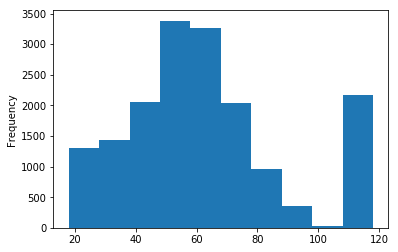

In [93]:
profile["age"].plot.hist();

Here we can see that all the individuals with age 118 also have all the missing values. The qustion is if 118 is also an indiction of missing?

In [94]:
profile[profile["age"] == 118].isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

About 13% of the users in the profile dataset have missing values.

In [95]:
len(profile[profile["age"] == 118])/len(profile)*100

12.794117647058822

Plot the histogram without the age = 118 years

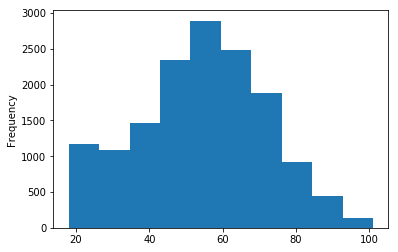

In [96]:
profile[profile["age"] != 118]["age"].plot.hist();

Convert "became_member_on" to datetime object

In [97]:
profile["became_member_on"] = pd.to_datetime(profile["became_member_on"], format='%Y%m%d')

In [98]:
profile["member_days"] = (pd.datetime.now() - profile["became_member_on"])/np.timedelta64(1, 'D')
profile["member_days"] = profile["member_days"].astype("int")

In [99]:
profile.drop("became_member_on", axis=1, inplace=True)

In [100]:
profile.head()

,age,gender,id,income,member_days
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1205
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1052
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,690
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1119
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,1032


There seems to about the same distribution what year people became a member for both age==118 and age!=118

Gender distribution

In [101]:
profile["gender"].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Income distribution

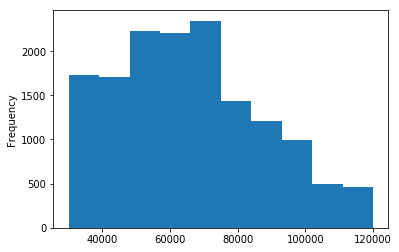

In [102]:
profile["income"].plot.hist();

### Clean up transcript value column

In [103]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [104]:
transcript.iloc[0]["value"]["offer id"]

'9b98b8c7a33c4b65b9aebfe6a799e6d9'

In [105]:
transcript[transcript["person"]=="78afa995795e4d85b5d9ceeca43f5fef"]

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


Extract the relevant information from "value" column. There are two different keys, "offer id" and "offer_id" which complicaits things slightly. Need to fix this

In [106]:
transcript["offer id"] = transcript["value"].apply(lambda x: x.get("offer id"))

In [107]:
transcript["offer_id"] = transcript["value"].apply(lambda x: x.get("offer_id"))

In [108]:
transcript["amount"] = transcript["value"].apply(lambda x: x.get("amount"))

Set the values for the "offer_id" cplumn to the "offer id" column when it is missing

In [109]:
transcript.loc[transcript["offer id"].isna(), "offer id"] = transcript["offer_id"]

Drop the "offer_id" and "value" column as its redundant

In [110]:
transcript.drop("offer_id", axis=1, inplace=True)

In [111]:
transcript.drop("value", axis=1, inplace=True)

In [112]:
transcript.isna().sum()

event            0
person           0
time             0
offer id    138953
amount      167581
dtype: int64

Just to make sure that there are no missing values when "offer id" is missing

In [113]:
transcript[transcript["offer id"].isna()]["amount"].isna().sum()

0

In [114]:
transcript[transcript["person"]=="78afa995795e4d85b5d9ceeca43f5fef"]#.head()

,event,person,time,offer id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,None,19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,None,29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,None,23.93


In [39]:
transcript1 = transcript[transcript["event"] == "transaction"].copy()
#transcript1.drop("offer id", inplace=True, axis=1)

In [40]:
transcript2 = transcript[transcript["event"] != "transaction"].copy()
transcript2.drop("amount", axis=1, inplace=True)

In [41]:
portfolio

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [42]:
transcript[transcript["person"]=="0020c2b971eb4e9188eac86d93036a77"]

,event,person,time,offer id,amount
1889,offer received,0020c2b971eb4e9188eac86d93036a77,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
18431,offer viewed,0020c2b971eb4e9188eac86d93036a77,12,fafdcd668e3743c1bb461111dcafc2a4,NaN
31326,transaction,0020c2b971eb4e9188eac86d93036a77,54,None,17.63
31327,offer completed,0020c2b971eb4e9188eac86d93036a77,54,fafdcd668e3743c1bb461111dcafc2a4,NaN
34287,transaction,0020c2b971eb4e9188eac86d93036a77,66,None,32.00
35751,transaction,0020c2b971eb4e9188eac86d93036a77,72,None,24.39
49660,transaction,0020c2b971eb4e9188eac86d93036a77,144,None,24.31
55085,offer received,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,NaN
112698,offer received,0020c2b971eb4e9188eac86d93036a77,336,fafdcd668e3743c1bb461111dcafc2a4,NaN
152505,offer received,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [84]:
test4 = pd.pivot_table(transcript2, values="time", index=["person", "offer id"], columns="event").reset_index()
test4.sort_values(by=["person", "offer received"], inplace=True)
test4 = test4[["person", "offer id", "offer received", "offer viewed", "offer completed"]]
test4.reset_index(col_level=0, drop=True, inplace=True)
test4.rename_axis(None, axis=1, inplace=True)
test4 = test4.merge(portfolio[["id", "offer_type"]], left_on="offer id", right_on="id").drop("id", axis=1).sort_values(["person", "offer received"])#columns.droplevel(0)#.stack(level=0)
test4.reset_index(drop=True, inplace=True)
test4

,person,offer id,offer received,offer viewed,offer completed,offer_type
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,informational
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,informational
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,bogo
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,discount
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,discount
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,372.0,423.0,NaN,bogo
6,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,6.0,NaN,informational
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,186.0,252.0,discount
8,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,336.0,354.0,NaN,informational
9,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,discount


In [85]:
transcript1[transcript1["person"]=="78afa995795e4d85b5d9ceeca43f5fef"]

,event,person,time,offer id,amount
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,None,19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,None,29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,None,23.93
218393,transaction,78afa995795e4d85b5d9ceeca43f5fef,510,None,21.72
230412,transaction,78afa995795e4d85b5d9ceeca43f5fef,534,None,26.56


In [86]:
transcript[transcript["person"]=="78afa995795e4d85b5d9ceeca43f5fef"]

,event,person,time,offer id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,None,19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,None,29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,None,23.93


In [87]:
nisse = transcript1.merge(test4, left_on="person", right_on="person")
nisse[nisse["person"]=="78afa995795e4d85b5d9ceeca43f5fef"]

,event,person,time,offer id_x,amount,offer id_y,offer received,offer viewed,offer completed,offer_type
390395,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6.0,132.0,bogo
390396,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,5a8bc65990b245e5a138643cd4eb9837,168.0,216.0,NaN,informational
390397,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,ae264e3637204a6fb9bb56bc8210ddfd,408.0,408.0,510.0,bogo
390398,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,f19421c1d4aa40978ebb69ca19b0e20d,504.0,582.0,510.0,bogo
390399,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6.0,132.0,bogo
390400,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,5a8bc65990b245e5a138643cd4eb9837,168.0,216.0,NaN,informational
390401,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,ae264e3637204a6fb9bb56bc8210ddfd,408.0,408.0,510.0,bogo
390402,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,f19421c1d4aa40978ebb69ca19b0e20d,504.0,582.0,510.0,bogo
390403,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,None,19.67,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6.0,132.0,bogo
390404,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,None,19.67,5a8bc65990b245e5a138643cd4eb9837,168.0,216.0,NaN,informational


## Merge the dataframes

In [88]:
profile.isna().sum()

age               0
gender         2175
id                0
income         2175
member_days       0
dtype: int64

In [89]:
transcript.isna().sum()

event            0
person           0
time             0
offer id    138953
amount      167581
dtype: int64

In [90]:
portfolio.isna().sum()

difficulty    0
duration      0
id            0
offer_type    0
reward        0
email         0
mobile        0
social        0
web           0
dtype: int64

Merge transcript and profile with an inner join. Then join that dataframe with the portfolio with a left join.

In [91]:
df_all = transcript.merge(profile, left_on="person", right_on="id")
df_all = df_all.merge(portfolio, left_on="offer id", right_on="id", how="left") 
df_all.head()

,event,person,time,offer id,amount,age,gender,id_x,income,member_days,difficulty,duration,id_y,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1117,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1117,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1117,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Make sure we still have the same amount of rows

In [92]:
len(df_all)

306534

Make sure the missing data is correct

In [93]:
df_all.isna().sum()

event               0
person              0
time                0
offer id       138953
amount         167581
age                 0
gender          33772
id_x                0
income          33772
member_days         0
difficulty     138953
duration       138953
id_y           138953
offer_type     138953
reward         138953
email          138953
mobile         138953
social         138953
web            138953
dtype: int64

Drop all id columns as they are not needed

In [94]:
#df_all.drop(["person", "offer id", "id_x", "id_y"], axis=1, inplace=True)
df_all.drop(["id_x", "id_y"], axis=1, inplace=True)

In [95]:
df_all.head()

,event,person,time,offer id,amount,age,gender,income,member_days,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,100000.0,1117,5.0,168.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,100000.0,1117,5.0,168.0,bogo,5.0,1.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,75,F,100000.0,1117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,100000.0,1117,5.0,168.0,bogo,5.0,1.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,75,F,100000.0,1117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
test = df_all[(df_all["person"]=="a6fce370a2ce4df995fc4899bfeb3b6a") | (df_all["person"] =="94de646f7b6041228ca7dec82adb97d2")].copy()

#test

In [97]:
offerid_lookup = portfolio.copy()
offerid_lookup["offer received"] = False
offerid_lookup["offer viewed"] = False
offerid_lookup["offer completed"] = False

In [98]:
offerid_lookup

,difficulty,duration,id,offer_type,reward,email,mobile,social,web,offer received,offer viewed,offer completed
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,False,False,False
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,False,False,False
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,False,False,False
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,False,False,False
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,False,False,False
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,False,False,False
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,False,False,False
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,False,False,False
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,False,False,False
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,False,False,False


In [99]:
offerid_lookup.loc[offerid_lookup["id"]=="ae264e3637204a6fb9bb56bc8210ddfd", "offer viewed"] =True
offerid_lookup.loc[offerid_lookup["id"]=="9b98b8c7a33c4b65b9aebfe6a799e6d9", "offer viewed"] =True

In [100]:
offerid_lookup[offerid_lookup["offer viewed"]==True].index.values.tolist()

[0, 3]

In [101]:
offer1, offer2, offer3, offer4 = [],[],[],[]

In [102]:
offer1, offer2, offer3, offer4

([], [], [], [])

In [103]:
len(df_all)

306534

In [66]:

offer_time = []
all_offer_ids = []
#offer_used_counter = 0
#number_of_offers = 0
#number_of_offers_viewed = 0
#offer_used = 0
#offer_active = False
#offer_viewed = False
#offer_used_viewed = 0
offer_diff_used_recieved = []
offer_diff_used_viewed = []
time_start = 0
all_trans_amounts = []
all_trans_times = []
offer_diff_trans_recieved = []
offer_diff_trans_viewed = []
prev_offer_viewed = []
prev_offer_difficulty = []
offer_time_viewed = []
offer_time_recieved = []
info_recieved_time = np.NaN
time_start_offer_recieved =np.NaN
info_time_array = []
offer_status = {}
offer_id = np.NaN
person_array = []
offer1, offer2, offer3, offer4, offer5, offer6, offer7, offer8, offer9, offer10 = [], [], [], [], [], [], [], [], [], []

#reset offerid_lookup table for each new person
offerid_lookup["offer received"] = False
offerid_lookup["offer viewed"] = False
offerid_lookup["offer completed"] = False

person = test.reset_index(drop=True).loc[0, "person"]

df2 = pd.DataFrame()


#for index, row in test.reset_index(drop=True).iterrows():
for index, row in tqdm.tqdm(df_all.iterrows(), total=len(df_all)):    
    #check if we are on a new person, if so reset all variables
    if (person != row["person"]) | (index+1 == len(test)):
        person = row["person"]
        #save values
        df = pd.DataFrame({"person_array":person_array, "trans_time":all_trans_times, "trans_amount":all_trans_amounts, 
                           "offer_time_recieved":offer_time_recieved, "offer_viewed_time": offer_time_viewed, 
                           "all_offer_ids":all_offer_ids, "cur_offer_viewed":prev_offer_viewed,
                   "offer_diff_trans_viewed": offer_diff_trans_viewed, "cur_offer_difficulty":prev_offer_difficulty, 
                   "info_time_array":info_time_array, "offer1":offer1, "offer2":offer2, "offer3":offer3, "offer4":offer4, 
                           "offer5":offer5, "offer6":offer6, "offer7":offer7, "offer8":offer8, "offer9":offer9, "offer10":offer10})
        df["offer_used"] = np.where(df["trans_amount"] >= df["cur_offer_difficulty"], True, False)
        df.loc[df["cur_offer_viewed"]==False, "offer_used"] = False
        df["time_last_trans"] = df["trans_time"].diff()
        df2 = pd.concat([df2, df])
        #reset values
        offer_time = []
        all_offer_ids = []
        #offer_used_counter = 0
        #number_of_offers = 0
        #number_of_offers_viewed = 0
        #offer_used = 0
        #offer_active = False
        #offer_viewed = False
        #offer_used_viewed = 0
        offer_diff_used_recieved = []
        offer_diff_used_viewed = []
        time_start = 0
        all_trans_amounts = []
        all_trans_times = []
        offer_diff_trans_recieved = []
        offer_diff_trans_viewed = []
        prev_offer_viewed = []
        prev_offer_difficulty = []
        offer_time_viewed = []
        offer_time_recieved = []
        info_recieved_time = np.NaN
        time_start_offer_recieved =np.NaN
        info_time_array = []
        offer_status = {}
        offer_id = np.NaN
        person_array = []
        offer1, offer2, offer3, offer4, offer5, offer6, offer7, offer8, offer9, offer10 = [], [], [], [], [], [], [], [], [], []
        #reset offerid_lookup table for each new person
        offerid_lookup["offer received"] = False
        offerid_lookup["offer viewed"] = False
        offerid_lookup["offer completed"] = False

    if row["event"] == "offer received":
        time_start_offer_recieved = row["time"]
        difficulty = row["difficulty"] # offer requirement
        offer_id = row["offer id"]

        offerid_lookup.loc[offerid_lookup["id"]==offer_id, "offer received"] = True
        offerid_lookup.loc[offerid_lookup["id"]==offer_id, "offer viewed"] = False
        offerid_lookup.loc[offerid_lookup["id"]==offer_id, "offer completed"] = False
        
                
    elif row["event"] == "offer viewed":
        time_start_offer_viewed = row["time"]    
        time_diff = time_start_offer_viewed - time_start_offer_recieved
        
        offerid_lookup.loc[offerid_lookup["id"]==row["offer id"], "offer viewed"] = True
            
  
    elif row["event"] == "offer completed":
        time_offer_completed = row["time"]
        time_diff = time_offer_completed - time_start_offer_recieved
        offer_time.append(time_diff)
        offer_id = row["offer id"]
        
        offerid_lookup.loc[offerid_lookup["id"]==offer_id, "offer received"] = False
        offerid_lookup.loc[offerid_lookup["id"]==offer_id, "offer viewed"] = False
        offerid_lookup.loc[offerid_lookup["id"]==offer_id, "offer completed"] = True      
        

        
    elif row["event"] == "transaction":
        all_trans_amounts.append(row["amount"])
        all_trans_times.append(row["time"])
        all_offer_ids.append(offer_id)
        person_array.append(person)
        
        
        for offer in offerid_lookup[offerid_lookup["offer viewed"]==True].index.values.tolist():
            eval("offer"+str(offer+1)).append(True)
        for offer in offerid_lookup[offerid_lookup["offer viewed"]==False].index.values.tolist():
            eval("offer"+str(offer+1)).append(False)
        
        #get difficulty value
        crit1 = offerid_lookup["offer viewed"] == True
        crit2 = offerid_lookup["offer_type"] != "informational"
        amount_threshold = offerid_lookup.loc[crit1 & crit2, "difficulty"].values
        
        #Setting time when offer informational
        #crit1 = offerid_lookup["offer viewed"] == True
        crit3 = offerid_lookup["offer_type"] == "informational"
        info_offer_df = offerid_lookup.loc[crit1 & crit3]
        if len(info_offer_df) > 0:
            info_recieved_time = time_start_offer_viewed
            offerid_lookup.loc[offerid_lookup["id"]==row["offer id"], "offer viewed"] = False   #this doesnt work, need to be fixed?
            
        info_time_array.append(info_recieved_time)
        
        offer_time_recieved.append(time_start_offer_recieved)
        
       
        if len(amount_threshold) > 0: #if offerviewed and not informational
            prev_offer_viewed.append(True)
            prev_offer_difficulty.append(amount_threshold[0])
            
            time_diff_recieved_use = row["time"] - time_start_offer_recieved #measure the time between offer use and recieved
            time_diff_viewed_use = row["time"] - time_start_offer_viewed #measure the time between offer use and viewed 
            offer_diff_trans_recieved.append(time_diff_recieved_use)
            offer_diff_trans_viewed.append(time_diff_viewed_use)
            offer_time_viewed.append(time_start_offer_viewed)
            
            if (row["amount"] >= amount_threshold).any(): #if offer used
                time_diff_recieved_use = row["time"] - time_start_offer_recieved #measure the time between offer use and recieved
                time_diff_viewed_use = row["time"] - time_start_offer_viewed #measure the time between offer use and viewed 
                offer_diff_used_recieved.append(time_diff_recieved_use)
                offer_diff_used_viewed.append(time_diff_viewed_use)

        else:           
            prev_offer_viewed.append(False)
            prev_offer_difficulty.append(0)
            offer_diff_trans_viewed.append(np.NaN)
            offer_time_viewed.append(np.NaN)

  0%|          | 730/306534 [00:03<23:17, 218.81it/s] 


KeyboardInterrupt: 

In [ ]:
df_all[df_all["person"]=='e2127556f4f64592b11af22de27a7932']


In [ ]:
test

In [ ]:
df2.to_csv("df2.csv")

In [115]:
df2 = pd.read_csv("df2.csv")

In [116]:
profile.head()

,age,gender,id,income,member_days
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1205
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1052
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,690
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1119
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,1032


In [117]:
transcript.head()

,event,person,time,offer id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [118]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [119]:
#df2.drop("Unnamed: 0", axis=1, inplace=True)
df2.head(20)

,Unnamed: 0,person_array,trans_time,trans_amount,offer_time_recieved,offer_viewed_time,all_offer_ids,cur_offer_viewed,offer_diff_trans_viewed,cur_offer_difficulty,info_time_array,offer1,offer2,offer3,offer4,offer5,offer6,offer7,offer8,offer9,offer10,offer_used,time_last_trans
0,0,78afa995795e4d85b5d9ceeca43f5fef,132.0,19.89,0.0,6.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,126.0,5.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN
1,1,78afa995795e4d85b5d9ceeca43f5fef,144.0,17.78,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,12.0
2,2,78afa995795e4d85b5d9ceeca43f5fef,222.0,19.67,168.0,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,NaN,0.0,216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,78.0
3,3,78afa995795e4d85b5d9ceeca43f5fef,240.0,29.72,168.0,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,NaN,0.0,216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,18.0
4,4,78afa995795e4d85b5d9ceeca43f5fef,378.0,23.93,168.0,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,NaN,0.0,216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,138.0
5,5,78afa995795e4d85b5d9ceeca43f5fef,510.0,21.72,504.0,408.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0,102.0,10.0,408.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,132.0
6,6,78afa995795e4d85b5d9ceeca43f5fef,534.0,26.56,504.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0.0,NaN,0.0,408.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,24.0
7,0,a03223e636434f42ac4c3df47e8bac43,234.0,1.09,0.0,6.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,228.0,20.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False,NaN
8,1,a03223e636434f42ac4c3df47e8bac43,264.0,3.50,0.0,6.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,258.0,20.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False,30.0
9,2,a03223e636434f42ac4c3df47e8bac43,612.0,0.06,576.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,NaN,0.0,336.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,348.0


In [120]:
df_trans_prof = pd.merge(df2, profile, left_on="person_array", right_on="id")
df_trans_prof_port = df_trans_prof.merge(portfolio, left_on="all_offer_ids", right_on="id")
#df_trans_prof_port.drop(["person_array", "all_offer_ids", "id_x", "id_y", "cur_offer_difficulty"], inplace=True, axis=1)
#df_trans_prof.drop(["person_array", "all_offer_ids", "id", "cur_offer_difficulty","offer_used", "offer_time_recieved", "offer_viewed_time", "cur_offer_viewed", "offer_diff_trans_viewed", "info_time_array", "trans_time", "time_last_trans"], inplace=True, axis=1)
df_trans_prof_port.drop(["Unnamed: 0", "person_array", "all_offer_ids", "id_x", "id_y"], inplace=True, axis=1)

In [121]:
df_trans_prof_port.head()

,trans_time,trans_amount,offer_time_recieved,offer_viewed_time,cur_offer_viewed,offer_diff_trans_viewed,cur_offer_difficulty,info_time_array,offer1,offer2,offer3,offer4,offer5,offer6,offer7,offer8,offer9,offer10,offer_used,time_last_trans,age,gender,income,member_days,difficulty,duration,offer_type,reward,email,mobile,social,web
0,132.0,19.89,0.0,6.0,1.0,126.0,5.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN,75,F,100000.0,1119,5,168,bogo,5,1,1,0,1
1,144.0,17.78,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,12.0,75,F,100000.0,1119,5,168,bogo,5,1,1,0,1
2,654.0,0.05,504.0,648.0,1.0,6.0,10.0,NaN,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,False,300.0,118,None,NaN,973,5,168,bogo,5,1,1,0,1
3,498.0,15.63,408.0,438.0,1.0,60.0,5.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,True,438.0,65,M,53000.0,843,5,168,bogo,5,1,1,0,1
4,180.0,2.68,168.0,174.0,1.0,6.0,5.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,36.0,118,None,NaN,1159,5,168,bogo,5,1,1,0,1


In [122]:
df_trans_prof_port["offer_used"] = df_trans_prof_port["offer_used"].astype("int")

In [123]:
df_trans_prof_port = pd.get_dummies(df_trans_prof_port, columns=["offer_type"])

In [124]:
df_trans_prof_port.shape

(134145, 34)

In [125]:
df_trans_prof = df_trans_prof_port

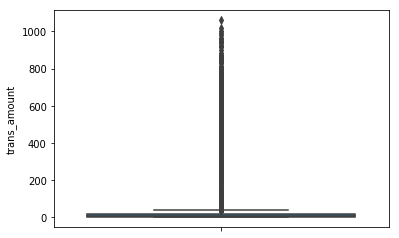

In [126]:
ax = sns.boxplot(y=df_trans_prof["trans_amount"] )

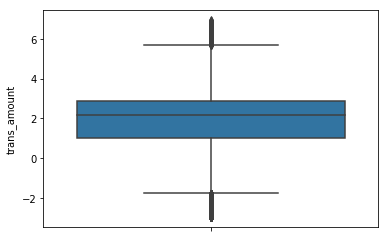

In [127]:
ax = sns.boxplot(y=np.log(df_trans_prof["trans_amount"]))

In [128]:
df_trans_prof[df_trans_prof["trans_amount"] > 100]

,trans_time,trans_amount,offer_time_recieved,offer_viewed_time,cur_offer_viewed,offer_diff_trans_viewed,cur_offer_difficulty,info_time_array,offer1,offer2,offer3,offer4,offer5,offer6,offer7,offer8,offer9,offer10,offer_used,time_last_trans,age,gender,income,member_days,difficulty,duration,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
537,618.0,437.11,576.0,588.0,1.0,30.0,5.0,NaN,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,150.0,73,F,75000.0,706,5,168,5,1,1,0,1,1,0,0
583,588.0,920.01,504.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,138.0,59,M,86000.0,1692,5,168,5,1,1,0,1,1,0,0
783,216.0,762.70,168.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,30.0,53,F,84000.0,994,5,168,5,1,1,0,1,1,0,0
1181,684.0,104.85,576.0,504.0,1.0,180.0,7.0,504.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,84.0,76,M,55000.0,1015,5,168,5,1,1,0,1,1,0,0
1840,606.0,575.03,504.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,60.0,64,F,73000.0,1365,5,168,5,1,1,0,1,1,0,0
1884,36.0,400.74,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12.0,81,F,57000.0,977,5,168,5,1,1,0,1,1,0,0
1963,456.0,377.19,408.0,420.0,1.0,36.0,10.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,30.0,21,F,36000.0,1479,5,168,5,1,1,0,1,1,0,0
3102,552.0,740.31,504.0,522.0,1.0,30.0,10.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,30.0,39,M,91000.0,1734,5,168,5,1,1,0,1,1,0,0
3458,78.0,105.24,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,42.0,74,M,68000.0,1914,5,168,5,1,1,0,1,1,0,0
3537,522.0,460.55,504.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,78.0,82,F,62000.0,1351,5,168,5,1,1,0,1,1,0,0


In [129]:
df_trans_prof["trans_amount"].describe()

count    134145.000000
mean         12.792609
std          30.345595
min           0.050000
25%           2.780000
50%           8.880000
75%          18.070000
max        1062.280000
Name: trans_amount, dtype: float64

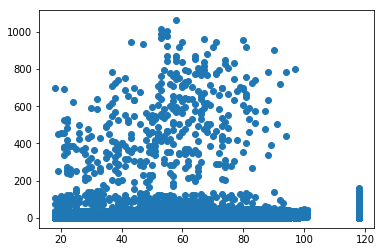

In [130]:
plt.scatter(df_trans_prof["age"], df_trans_prof["trans_amount"])

In [131]:
df_trans_prof = df_trans_prof_port

In [132]:
df_trans_prof.fillna(0, inplace=True)

In [133]:
for col in df_trans_prof.columns:
    if "offer" in col and "_" not in col:
        df_trans_prof[col] = df_trans_prof[col].astype("int")

Add feature if gender is missing.
Fill missing with mode.
Get dummes from gender.

In [134]:
df_trans_prof["gender_missing"] = np.where(df_trans_prof["gender"].isna(), 1, 0)
df_trans_prof["gender"] = df_trans_prof["gender"].fillna(df_trans_prof["gender"].mode())
df_trans_prof = pd.get_dummies(df_trans_prof,columns=["gender"])

Add feature for age missing, fill with median values

In [135]:
df_trans_prof["age_missing"] = np.where(df_trans_prof["age"].isna(), 1, 0)
df_trans_prof["age"] = df_trans_prof["age"].fillna(df_trans_prof["age"].median())

Income missing add feature and fillna with median.

In [136]:
df_trans_prof["income_missing"] = np.where(df_trans_prof["income"].isna(), 1, 0)
df_trans_prof["income"] = df_trans_prof["income"].fillna(df_trans_prof["income"].median())

Look foroutliers for trans_amount with Tukey rule

In [137]:
#df_trans_prof = df_trans_prof[df_trans_prof["trans_amount"]<100]
df_trans_prof["trans_amount"] = np.log(df_trans_prof["trans_amount"])
Q1,Q3 = np.percentile(df_trans_prof["trans_amount"], [25, 75])
IQR = Q3 - Q1
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)
crit1 = df_trans_prof["trans_amount"] > lower_range
crit2 = df_trans_prof["trans_amount"] < upper_range

New dataframe with outliers for trans_amount removed

In [138]:
df_trans_prof = df_trans_prof[crit1 & crit2]

In [139]:
X = df_trans_prof.drop("trans_amount", axis=1)
y = df_trans_prof["trans_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [140]:
!pip install hyperopt

In [141]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [142]:
from sklearn.model_selection import cross_val_score

In [143]:
X_train.shape

(88689, 39)

In [144]:
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:

def acc_model(params):
    clf = RandomForestRegressor(**params, random_state=42)
    #return cross_val_score(clf, X_train[:100], y_train[:100]).mean()
    print("Train model")
    print(params)
    clf.fit(X_train[:40000], y_train[:40000])
    y_pred = clf.predict(X_test)
    return metrics.r2_score(y_test, y_pred)

param_space = {
    'max_depth': hp.choice('max_depth', range(2, 20)), #1,20
    #'max_features': hp.choice('max_features', range(1,150)),
    'n_estimators': hp.choice('n_estimators', range(10, 500)), #1,500
    'criterion': hp.choice('criterion', ["mse", "mae"]),
    "min_samples_split": hp.choice("min_samples_split", range(2, 10)),#20)),
    "max_features": hp.choice("max_features", ["auto", "sqrt", "log2"]),
    "min_samples_leaf": hp.choice("min_samples_leaf", range(1, 4))}#10))}#,
    #"max_leaf_nodes": hp.choice("max_leaf_nodes", range(1, 10000))}#,
    ##"max_samples": hp.choice("max_samples", range(1,10000))}

best = 0
accuracy = []
params_list = []
def f(params):
    global best
    acc = acc_model(params)
    accuracy.append(acc)
    params_list.append(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:')
print (best)

Train model    | 0/10 [00:00<?, ?trial/s, best loss=?]
{'criterion': 'mae', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 26}
new best:      | 0/10 [00:00<?, ?trial/s, best loss=?]
0.582860902105 | 0/10 [03:49<?, ?trial/s, best loss=?]
{'criterion': 'mae', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 26}
Train model    | 1/10 [03:49<34:28, 229.88s/trial, best loss: -0.5828609021048191]
{'criterion': 'mae', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 336}
 10%|█         | 1/10 [03:49<34:28, 229.88s/trial, best loss: -0.5828609021048191]

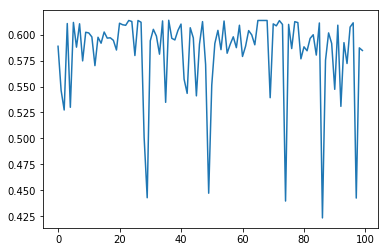

In [129]:
plt.plot(accuracy)

In [125]:
trials.best_trial#['result']#['loss']

{'state': 2,
 'tid': 72,
 'spec': None,
 'result': {'loss': -0.6077715277346742, 'status': 'ok'},
 'misc': {'tid': 72,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'criterion': [72],
   'max_depth': [72],
   'max_features': [72],
   'min_samples_leaf': [72],
   'min_samples_split': [72],
   'n_estimators': [72]},
  'vals': {'criterion': [0],
   'max_depth': [6],
   'max_features': [0],
   'min_samples_leaf': [2],
   'min_samples_split': [12],
   'n_estimators': [213]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 5, 30, 13, 55, 2, 91000),
 'refresh_time': datetime.datetime(2020, 5, 30, 13, 55, 3, 631000)}

Run random forest model

In [191]:
rfr = RandomForestRegressor(n_estimators=500,random_state=42, min_samples_split=4, max_depth=7)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [192]:
y_train_predict = rfr.predict(X_train)
y_test_predict = rfr.predict(X_test)

In [193]:
rmse_train = metrics.mean_squared_error(y_train, y_train_predict)
rmse_test = metrics.mean_squared_error(y_test, y_test_predict)
r2_train = metrics.r2_score(y_train, y_train_predict)
r2_test = metrics.r2_score(y_test, y_test_predict)

min_samples_split=4 instead of 2, max_depth=8 instead of None

In [194]:
print(f"rmse_train: {rmse_train}, rmse_test: {rmse_test}, r2_train: {r2_train}, r2_test: {r2_test}")

rmse_train: 0.5319585128903879, rmse_test: 0.5250357278408002, r2_train: 0.6379206765462146, r2_test: 0.636612692829901


min_samples_split=4 instead of 2

In [190]:
print(f"rmse_train: {rmse_train}, rmse_test: {rmse_test}, r2_train: {r2_train}, r2_test: {r2_test}")

rmse_train: 0.09017558599839502, rmse_test: 0.4814216190401374, r2_train: 0.9386216887611397, r2_test: 0.6667988548590538


More feautres

In [186]:
print(f"rmse_train: {rmse_train}, rmse_test: {rmse_test}, r2_train: {r2_train}, r2_test: {r2_test}")

rmse_train: 0.06662627165747466, rmse_test: 0.48439126951599115, r2_train: 0.954650607554132, r2_test: 0.6647435027516937


In [91]:
print(f"rmse_train: {rmse_train}, rmse_test: {rmse_test}, r2_train: {r2_train}, r2_test: {r2_test}")

rmse_train: 0.0823320795884512, rmse_test: 0.5881466640336916, r2_train: 0.9438203438702485, r2_test: 0.5949455519881988


In [92]:
#df2 = pd.DataFrame()
df3 = pd.read_csv("df_res.csv")
#df3.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1, inplace=True)

In [93]:
a = [["500trees, log(amount), remove outliers, age feature 118 fixed", rmse_train, rmse_test, r2_train, r2_test]]
df = pd.DataFrame(a, columns=["comment", " rmse_train", "rmse_test", "r2_train", "r2_test"])
df3 = pd.concat([df3, df])
df3

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,rmse_train,Unnamed: 0,Unnamed: 0.1,comment,r2_test,r2_train,rmse_test
0,442.636689,0.0,0.0,baseline,-0.246809,0.531839,1064.024877
1,472.865935,1.0,0.0,"test_size=0.2, p=0.33",-0.226883,0.495648,1012.396055
2,487.709357,2.0,0.0,test_size=0.1,-0.161174,0.475906,900.756187
3,485.745109,3.0,0.0,"test_size=0.1, age feature 118 fixed",-0.168647,0.478017,906.552915
4,442.878016,4.0,0.0,"baseline, age feature 118 fixed",-0.233599,0.531584,1052.751591
5,440.610484,5.0,0.0,"500trees, age feature 118 fixed",-0.239646,0.533982,1057.912381
6,479.841361,6.0,0.0,"10trees, age feature 118 fixed",-0.302910,0.492489,1111.901391
7,15.399090,7.0,0.0,"baseline, remove amount > 100, age feature 118...",0.598271,0.843437,39.577188
0,0.082332,NaN,NaN,"500trees, log(amount), remove outliers, age fe...",0.594946,0.943820,0.588147


In [94]:
data = list(zip(X_train.columns, rfr.feature_importances_))
df_imp = pd.DataFrame(data, columns=["feature", "importance"])
df_imp.sort_values("importance", ascending=False)

,feature,importance
12,income,0.385663
13,member_days,0.192710
0,Unnamed: 0,0.116337
11,age,0.109813
19,income_missing,0.034687
14,gender_missing,0.033371
16,gender_M,0.022959
1,offer1,0.013295
8,offer8,0.012789
2,offer2,0.012345


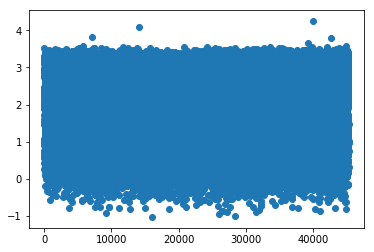

In [95]:
plt.scatter(x=list(range(0,len(y_test_predict))),y=y_test_predict)

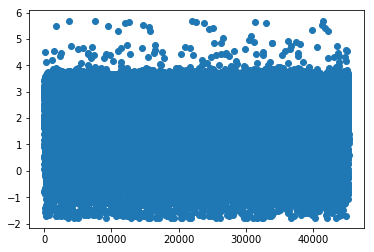

In [96]:
plt.scatter(x=list(range(0,len(y_test))),y=y_test)